## Watchlist Dataset

In [1]:
import pandas as pd

# Load the Watchlist sheet from the Excel file
file_path = 'Movies Ranks.xlsm'
watchlist_df = pd.read_excel(file_path, sheet_name='Watchlist')

# Display the first few rows to verify
watchlist_df.head()


,Created,Movie,IMDb,Runtime,Year,Genres,Genre1,Genre2,Genre3,Num Votes,Release Date,Directors,Director,RT,Cast,Actor,Actor 2,Actor 3,Actor 4
0,2024-01-04,Friday Night Lights,7.2,118,2004,"Action, Drama, Sport",Action,Drama,Sport,69000.0,2004-10-08,Peter Berg,Peter Berg,82,"Billy Bob Thornton, Jay Hernandez, Derek Luke,...",Billy Bob Thornton,Jay Hernandez,Derek Luke,Lucas Black
1,2024-05-19,Bullet Train,7.3,127,2022,"Action, Comedy, Thriller",Action,Comedy,Thriller,496237.0,2022-08-05,David Leitch,David Leitch,70,"Brad Pitt, Joey King, Aaron Taylor-Johnson, Br...",Brad Pitt,Joey King,Aaron Taylor-Johnson,Brian Tyree Henry
2,2022-06-06,Braveheart,8.3,178,1995,"Biography, Drama, War",Biography,Drama,War,1132611.0,1995-05-24,Mel Gibson,Mel Gibson,78,"Mel Gibson, Sophie Marceau, Patrick McGoohan, ...",Mel Gibson,Sophie Marceau,Patrick McGoohan,Angus Macfadyen
3,2022-06-09,22 Jump Street,7.0,112,2014,"Action, Comedy, Crime",Action,Comedy,Crime,424768.0,2014-06-13,"Phil Lord, Christopher Miller",Phil Lord,85,NaN,Channing Tatum,Jonah Hill,Ice Cube,NaN
4,2022-06-09,Ted 2,6.3,115,2015,Comedy,Comedy,NaN,NaN,249047.0,2015-06-26,Seth MacFarlane,Seth MacFarlane,45,NaN,Mark Wahlberg,Seth MacFarlane,Amanda Seyfried,NaN


In [2]:
import pandas as pd

# === Load Watchlist sheet from Excel ===
file_path = 'Movies Ranks.xlsm'
watchlist_df_excel = pd.read_excel(file_path, sheet_name='Watchlist')

# Start with Movie column
watchlist_movies = watchlist_df_excel[['Movie']].copy()

# Add all required columns, now including Runtime and actors
columns = ['Year', 'Runtime', 'Actor', 'Actor 2', 'Actor 3', 'Actor 4', 'Director',
           'Genre1', 'Genre2', 'Genre3', 'IMDb', 'RT', 'Created']
for col in columns:
    watchlist_movies[col] = None

# === Fill in values from Excel's Watchlist sheet ===
fields_to_merge = ['Movie', 'Year', 'Runtime', 'Genre1', 'Genre2', 'Genre3', 'IMDb', 'Director',
                   'Actor', 'Actor 2', 'Actor 3', 'Actor 4', 'Created']  # <-- include actors here
watchlist_movies = watchlist_movies.merge(
    watchlist_df_excel[fields_to_merge],
    on='Movie',
    how='left',
    suffixes=('', '_from_excel')
)
for field in ['Year', 'Runtime', 'Genre1', 'Genre2', 'Genre3', 'IMDb', 'Director',
              'Actor', 'Actor 2', 'Actor 3', 'Actor 4', 'Created']:  # <-- and here
    watchlist_movies[field] = watchlist_movies[f'{field}_from_excel']
    watchlist_movies.drop(columns=[f'{field}_from_excel'], inplace=True)

# === Load Rotten Tomatoes sheet and merge RT scores ===
rt_df = pd.read_excel(file_path, sheet_name='rotten_tomatoes_movies')
rt_df = rt_df.drop_duplicates(subset='movie_title')
watchlist_movies = watchlist_movies.merge(
    rt_df[['movie_title', 'tomatometer_rating']],
    left_on='Movie',
    right_on='movie_title',
    how='left'
)
watchlist_movies['RT'] = watchlist_movies['tomatometer_rating']
watchlist_movies.drop(columns=['movie_title', 'tomatometer_rating'], inplace=True)

'''# === Load movie_metadata.csv and add top 3 actors ===
actor_df = pd.read_csv('movie_metadata.csv')
actor_df['movie_title_clean'] = actor_df['movie_title'].str.strip().str.lower()
actor_df = actor_df.drop_duplicates(subset='movie_title_clean')'''
'''
# Normalize title for matching
watchlist_movies['Movie_clean'] = watchlist_movies['Movie'].str.strip().str.lower()

# Merge actor data
watchlist_movies = watchlist_movies.merge(
    actor_df[['movie_title_clean', 'actor_1_name', 'actor_2_name', 'actor_3_name']],
    left_on='Movie_clean',
    right_on='movie_title_clean',
    how='left'
)
watchlist_movies['Actor'] = watchlist_movies['actor_1_name'].combine_first(watchlist_movies['Actor'])
watchlist_movies['Actor 2'] = watchlist_movies['actor_2_name'].combine_first(watchlist_movies['Actor 2'])
watchlist_movies['Actor 3'] = watchlist_movies['actor_3_name'].combine_first(watchlist_movies['Actor 3'])
watchlist_movies.drop(columns=['actor_1_name', 'actor_2_name', 'actor_3_name', 'movie_title_clean'], inplace=True)
# === Fallback: Fill from Cast in IMDB_Movies_Dataset ===
imdb_cast_df = pd.read_excel(file_path, sheet_name='IMDB_Movies_Dataset')
imdb_cast_df['Title_clean'] = imdb_cast_df['Title'].str.strip().str.lower()
imdb_cast_df = imdb_cast_df.drop_duplicates(subset='Title_clean')

# Merge Cast
watchlist_movies['Movie_clean'] = watchlist_movies['Movie'].str.strip().str.lower()
watchlist_movies = watchlist_movies.merge(
    imdb_cast_df[['Title_clean', 'Cast']],
    left_on='Movie_clean',
    right_on='Title_clean',
    how='left'
)

# Fill missing actors from Cast
def fill_actors_from_cast(row):
    if pd.notna(row['Cast']):
        cast_list = [x.strip() for x in row['Cast'].split(',')]
        if pd.isna(row['Actor']) and len(cast_list) > 0:
            row['Actor'] = cast_list[0]
        if pd.isna(row['Actor 2']) and len(cast_list) > 1:
            row['Actor 2'] = cast_list[1]
        if pd.isna(row['Actor 3']) and len(cast_list) > 2:
            row['Actor 3'] = cast_list[2]
        if pd.isna(row['Actor 4']) and len(cast_list) > 3:
            row['Actor 4'] = cast_list[3]
    return row

watchlist_movies = watchlist_movies.apply(fill_actors_from_cast, axis=1)

# === Final cleanup: drop helper columns ===
watchlist_movies.drop(columns=['Movie_clean', 'Title_clean', 'Cast'], inplace=True)'''

# === Fill missing values ===
categorical_cols = ['Actor', 'Actor 2', 'Actor 3', 'Actor 4', 'Director',
                    'Genre1', 'Genre2', 'Genre3', 'Created']
watchlist_movies[categorical_cols] = watchlist_movies[categorical_cols].fillna('Unknown')

numerical_cols = ['Year', 'Runtime', 'IMDb', 'RT']
for col in numerical_cols:
    if col in watchlist_movies.columns:
        mean_value = watchlist_movies[col].mean()
        watchlist_movies[col] = watchlist_movies[col].fillna(mean_value)

# === Manual fixes for corrupted characters ===
replacements = {
    'TimothÃ©e Chalamet': 'Timothee Chalamet',
    'Men in BlackÂ³': 'Men in Black 3',
    'LÃ©on: The Professional': 'Léon: The Professional',
    'Stellan SkarsgÃ¥rd': 'Stellan Skarsgård',
    'LÃ©a Seydoux': 'Léa Seydoux',
    'Hardy KrÃ¼ger': 'Hardy Krüger',
    'Baltasar KormÃ¡kur': 'Baltasar Kormákur',
    'Alejandro G. IÃ±Ã¡rritu': 'Alejandro G. Iñárritu',
    'CÃ©dric Jimenez': 'Cédric Jimenez',
    'Jean-Marc VallÃ©e': 'Jean-Marc Vallée',
    'ZoÃ« Kravitz': 'Zoe Kravitz',
    'Hanno PÃ¶schl':'Hanno Poschl'
}

columns_to_fix = ['Movie', 'Actor', 'Actor 2', 'Actor 3', 'Actor 4','Director']
for col in columns_to_fix:
    watchlist_movies[col] = watchlist_movies[col].replace(replacements)

# === Final deduplication just in case ===
watchlist_movies = watchlist_movies.drop_duplicates(subset='Movie')

# === Save final version ===
watchlist_movies.to_csv('Watchlist.csv', index=False)

# Preview
watchlist_movies.head(315)

,Movie,Year,Runtime,Actor,Actor 2,Actor 3,Actor 4,Director,Genre1,Genre2,Genre3,IMDb,RT,Created
0,Friday Night Lights,2004,118,Billy Bob Thornton,Jay Hernandez,Derek Luke,Lucas Black,Peter Berg,Action,Drama,Sport,7.2,82.000000,2024-01-04
1,Bullet Train,2022,127,Brad Pitt,Joey King,Aaron Taylor-Johnson,Brian Tyree Henry,David Leitch,Action,Comedy,Thriller,7.3,69.634686,2024-05-19
2,Braveheart,1995,178,Mel Gibson,Sophie Marceau,Patrick McGoohan,Angus Macfadyen,Mel Gibson,Biography,Drama,War,8.3,78.000000,2022-06-06
3,22 Jump Street,2014,112,Channing Tatum,Jonah Hill,Ice Cube,Unknown,Phil Lord,Action,Comedy,Crime,7.0,85.000000,2022-06-09
4,Ted 2,2015,115,Mark Wahlberg,Seth MacFarlane,Amanda Seyfried,Unknown,Seth MacFarlane,Comedy,Unknown,Unknown,6.3,45.000000,2022-06-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,12 Strong,2018,130,Chris Hemsworth,Michael Shannon,Michael Pena,Unknown,Nicolai Fuglsig,Action,Drama,History,6.5,50.000000,2025-05-04
308,The Monuments Men,2014,118,George Clooney,Matt Damon,Bill Murray,Unknown,George Clooney,Biography,Comedy,Drama,6.1,30.000000,2025-05-08
309,Grand Prix,1966,176,James Garner,Eva Marie Saint,Yves Montand,Unknown,John Frankenheimer,Drama,Sport,Unknown,7.2,100.000000,2025-05-24
310,Major League II,1994,105,Charlie Sheen,Tom Berenger,Corbin Bernsen,Unknown,David S. Ward,Comedy,Sport,Unknown,5.6,5.000000,2025-06-20


In [3]:
import pandas as pd
import re

# === Load Watchlist.csv ===
watchlist_movies = pd.read_csv('Watchlist.csv')

# === Define suspicious characters often caused by encoding issues ===
suspicious_chars = r"[ÂÃ�“”�¢™¤©®±³¼½¾]"

# === Check Movie titles ===
suspicious_titles = watchlist_movies[watchlist_movies['Movie'].str.contains(suspicious_chars, regex=True, na=False)]
print("⚠️ Suspicious movie titles:")
print(suspicious_titles['Movie'].unique())

# === Check actor fields ===
for actor_col in ['Actor', 'Actor 2', 'Actor 3', 'Actor 4','Director']:
    if actor_col in watchlist_movies.columns:
        matches = watchlist_movies[watchlist_movies[actor_col].str.contains(suspicious_chars, regex=True, na=False)]
        if not matches.empty:
            print(f"\n⚠️ Suspicious entries in {actor_col}:")
            print(matches[actor_col].unique())


⚠️ Suspicious movie titles:
[]


In [4]:
# Normalize genres (strip spaces and lowercase)
for col in ['Genre1', 'Genre2', 'Genre3']:
    watchlist_movies[col] = watchlist_movies[col].str.strip().str.lower()

# Identify rows with duplicate genres
def has_duplicate_genres(row):
    genres = [row['Genre1'], row['Genre2'], row['Genre3']]
    genres = [g for g in genres if g and g != 'unknown']
    return len(genres) != len(set(genres))

# Filter and show only rows with similar genre values
duplicates_df = watchlist_movies[watchlist_movies.apply(has_duplicate_genres, axis=1)]

# Display relevant info
duplicates_df[['Movie', 'Genre1', 'Genre2', 'Genre3']]


,Movie,Genre1,Genre2,Genre3


## Movie Predictions

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
import joblib
from openpyxl import load_workbook
from openpyxl.utils import get_column_letter

In [6]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl")

df = pd.read_excel('Movies Ranks.xlsm', sheet_name="Movie Rankings")

# Drop unnecessary columns
df = df.drop(columns=["Year.1", "(Multiple Items)",'Critics','All'], errors="ignore")

In [7]:
df = df[df['Score'] >= 5.0]

##### Find Best Combination of Columns

In [8]:
"""from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Feature sets to test
feature_sets = {
    "All Features": ['Year', 'Actor', 'Actor 2', 'Actor 3', 'Actor 4', 
                     'Director', 'Genre1', 'Genre2', 'Genre3', 'IMDb', 'RT'],

    "No Year": ['Actor', 'Actor 2', 'Actor 3', 'Actor 4', 
                'Director', 'Genre1', 'Genre2', 'Genre3', 'IMDb', 'RT'],

    "Genres + Ratings Only": ['Genre1', 'Genre2', 'Genre3', 'IMDb', 'RT'],

    "Actors + Ratings Only": ['Actor', 'Actor 2', 'Actor 3', 'Actor 4', 'IMDb', 'RT'],

    "Just Ratings": ['IMDb', 'RT']
}

# Store results
results = {}

# Loop through feature sets
for name, cols in feature_sets.items():
    X_subset = X[cols]

    # Identify types
    cat_cols = [col for col in cols if X[col].dtype == 'object']
    num_cols = [col for col in cols if X[col].dtype != 'object']

    # Build pipeline
    preprocessor = ColumnTransformer([
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('num', 'passthrough', num_cols)
    ])

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(random_state=42))
    ])

    # Fit model
    pipeline.fit(X_train[cols], y_train)

    # Predict
    y_pred = pipeline.predict(X_test[cols])

    # Evaluate
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Store
    results[name] = {
        'MAE': round(mae, 3),
        'RMSE': round(rmse, 3),
        'R2': round(r2, 3)
    }

# Show all results
pd.DataFrame(results).T.sort_values(by='RMSE')"""


'from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score\nfrom sklearn.pipeline import Pipeline\nfrom sklearn.compose import ColumnTransformer\nfrom sklearn.preprocessing import OneHotEncoder\nfrom sklearn.ensemble import RandomForestRegressor\nimport numpy as np\n\n# Feature sets to test\nfeature_sets = {\n    "All Features": [\'Year\', \'Actor\', \'Actor 2\', \'Actor 3\', \'Actor 4\', \n                     \'Director\', \'Genre1\', \'Genre2\', \'Genre3\', \'IMDb\', \'RT\'],\n\n    "No Year": [\'Actor\', \'Actor 2\', \'Actor 3\', \'Actor 4\', \n                \'Director\', \'Genre1\', \'Genre2\', \'Genre3\', \'IMDb\', \'RT\'],\n\n    "Genres + Ratings Only": [\'Genre1\', \'Genre2\', \'Genre3\', \'IMDb\', \'RT\'],\n\n    "Actors + Ratings Only": [\'Actor\', \'Actor 2\', \'Actor 3\', \'Actor 4\', \'IMDb\', \'RT\'],\n\n    "Just Ratings": [\'IMDb\', \'RT\']\n}\n\n# Store results\nresults = {}\n\n# Loop through feature sets\nfor name, cols in feature_sets.items():\

##### Features

In [9]:
features = ['Year', 'Actor', 'Actor 2', 'Actor 3','Director', 'Genre1', 'Genre2', 'Genre3', 'IMDb', 'RT','Runtime']

target = 'Score'

X = df[features]
y = df[target]

In [10]:
cat_cols = ['Actor', 'Actor 2', 'Actor 3', 'Director', 'Genre1', 'Genre2', 'Genre3']
num_cols = ['Year', 'IMDb', 'RT','Runtime']
X.loc[:, cat_cols] = X[cat_cols].fillna('Unknown')
X.loc[:, num_cols] = X[num_cols].fillna(X[num_cols].mean())

<Axes: >

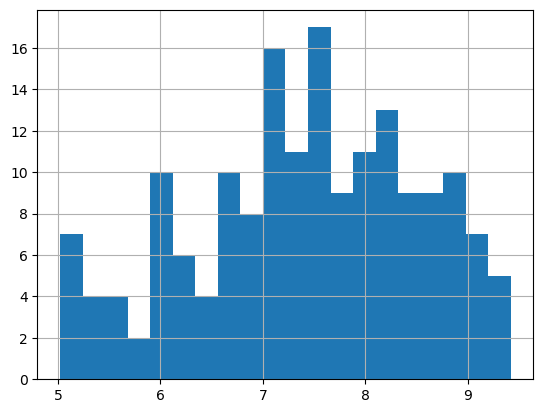

In [11]:
df['Score'].hist(bins=20)

In [12]:
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train_raw, y_test_raw = train_test_split(X, y, test_size=0.2, random_state=42)

# Reinitialize to avoid setting with copy warning
X_train = X_train.copy()
X_test = X_test.copy()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('num', StandardScaler(), num_cols)
    ])

# Scale target
target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train_raw.values.reshape(-1, 1)).ravel()
y_test_scaled = target_scaler.transform(y_test_raw.values.reshape(-1, 1)).ravel()

results = {}

def evaluate_model(name, model, scale_target=False):
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    # Choose whether to use scaled or unscaled y
    if scale_target:
        pipeline.fit(X_train, y_train_scaled)
        y_pred_scaled = pipeline.predict(X_test)
        y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
    else:
        pipeline.fit(X_train, y_train_raw)
        y_pred = pipeline.predict(X_test)

    mae = mean_absolute_error(y_test_raw, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_raw, y_pred))
    r2 = r2_score(y_test_raw, y_pred)

    results[name] = {
        "MAE": round(mae, 3),
        "RMSE": round(rmse, 3),
        "R2": round(r2, 3)
    }

    print(f"{name} — MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")

# Tree-based models (no need to scale y)
evaluate_model("Random Forest", RandomForestRegressor(random_state=42))
evaluate_model("Decision Tree", DecisionTreeRegressor(random_state=42))
evaluate_model("Gradient Boosting", GradientBoostingRegressor(random_state=42))
evaluate_model("XGBoost", XGBRegressor(n_estimators=100, random_state=42))

# Non-tree models (scale y)
evaluate_model("Linear Regression", LinearRegression(), scale_target=True)
evaluate_model("KNN", KNeighborsRegressor(), scale_target=True)
evaluate_model("Ridge Regression", Ridge(alpha=1.0), scale_target=True)
evaluate_model("Lasso Regression", Lasso(alpha=0.1, max_iter=10000), scale_target=True)

# View sorted results
pd.DataFrame(results).T.sort_values(by="RMSE")


Random Forest — MAE: 0.97, RMSE: 1.18, R²: -0.05
Decision Tree — MAE: 1.20, RMSE: 1.47, R²: -0.65
Gradient Boosting — MAE: 0.94, RMSE: 1.17, R²: -0.05
XGBoost — MAE: 1.08, RMSE: 1.35, R²: -0.38
Linear Regression — MAE: 1.28, RMSE: 1.61, R²: -0.98
KNN — MAE: 0.93, RMSE: 1.12, R²: 0.04
Ridge Regression — MAE: 0.98, RMSE: 1.17, R²: -0.05
Lasso Regression — MAE: 0.93, RMSE: 1.06, R²: 0.15


,MAE,RMSE,R2
Lasso Regression,0.926,1.057,0.146
KNN,0.934,1.123,0.037
Gradient Boosting,0.942,1.173,-0.051
Ridge Regression,0.981,1.173,-0.050
Random Forest,0.975,1.175,-0.055
XGBoost,1.081,1.345,-0.382
Decision Tree,1.198,1.471,-0.652
Linear Regression,1.284,1.609,-0.978


In [13]:
# Rebuild full pipeline using all features
final_cols = ['Year', 'Actor', 'Actor 2', 'Actor 3',
              'Director', 'Genre1', 'Genre2', 'Genre3', 'IMDb', 'RT','Runtime']

cat_cols = [col for col in final_cols if X[col].dtype == 'object']
num_cols = [col for col in final_cols if X[col].dtype != 'object']

final_preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('num', 'passthrough', num_cols)
])

final_pipeline = Pipeline(steps=[
    ('preprocessor', final_preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

"""final_pipeline = Pipeline(steps=[
    ('preprocessor', final_preprocessor),
    ('regressor', XGBRegressor(random_state=42, verbosity=0))
])"""

# Retrain on full dataset
final_pipeline.fit(X[final_cols], y)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Actor', 'Actor 2',
                                                   'Actor 3', 'Director',
                                                   'Genre1', 'Genre2',
                                                   'Genre3']),
                                                 ('num', 'passthrough',
                                                  ['Year', 'IMDb', 'RT',
                                                   'Runtime'])])),
                ('regressor', GradientBoostingRegressor(random_state=42))])

In [14]:
# Save pipeline (includes preprocessing + model)
joblib.dump(final_pipeline, 'movie_score_predictor.pkl')
model = joblib.load('movie_score_predictor.pkl')

input_file = 'Watchlist.csv'
df = pd.read_csv(input_file)

# Define the columns used by the model
model_features = ['Year', 'Actor', 'Actor 2', 'Actor 3', 'Actor 4',
                  'Director', 'Genre1', 'Genre2', 'Genre3', 'IMDb', 'RT','Runtime']

# Fill missing values as done during training
cat_cols = [col for col in model_features if df[col].dtype == 'object']
num_cols = [col for col in model_features if df[col].dtype != 'object']

df[cat_cols] = df[cat_cols].fillna('Unknown')
df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

# Predict scores using the model
df['Predicted Score'] = model.predict(df[model_features])

# Optional: Round the predicted score
df['Predicted Score'] = df['Predicted Score'].round(2)

# Save results to a new Excel file
output_file = 'Predicted_Movie_Scores.xlsx'
df.to_excel(output_file, index=False)

print(f"Predictions saved to: {output_file}")

Predictions saved to: Predicted_Movie_Scores.xlsx
